In [41]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import torch
import sys
sys.path.insert(0, '../scripts/')
# from models import model_dict
from dataset import Galaxy10DECalsTest
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from e2cnn import nn as e2cnn_nn
from cnn import ConvBlock as CNN_ConvBlock
import cnn
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import warnings
device = ('cuda' if torch.cuda.is_available() else 'cpu')

class GradCAM:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.feature = None
        self.gradient = None

    def save_gradient(self, module, grad_input, grad_output):
        self.gradient = grad_output[0]

    def __call__(self, x, index=None):
        # Register hook for the last convolution layer
        final_layer = list(dict(self.model.named_children()).values())[-5] # Last convolution layer
        final_layer.register_forward_hook(self.save_feature)
        final_layer.register_backward_hook(self.save_gradient)

        # Forward
        logits = self.model(x)
        if index == None:
            index = np.argmax(logits.cpu().data.numpy())

        # Create a one-hot tensor for the predicted class
        one_hot = np.zeros((1, logits.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.to(device) * logits)

        # Backward
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        # Get pooled gradients
        weights = torch.mean(self.gradient, dim=(2, 3), keepdim=True)
        activation_maps = F.relu(torch.sum(weights * self.feature, dim=1)).squeeze()

        return activation_maps

    def save_feature(self, module, input, output):
        self.feature = output

def visualize(img, cam):
    # Normalize the CAM so values are between 0 and 1
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam = np.uint8(cam * 255)
    resized_cam = cv2.resize(cam, (255,255))
    heatmap = cv2.applyColorMap(resized_cam, cv2.COLORMAP_JET)
    
    # Convert your torch tensor image to numpy
    img = img.cpu().numpy()
    img = np.uint8(img * 255)  # Convert from [0,1] to [0,255]
    
    out = cv2.addWeighted(img, 0.8, heatmap, 0.2, 0)
    return out

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(255)
])
og_data = Galaxy10DECalsTest('../../data/GCNN_imbalanced/test_data_imbalanced.hdf5', transform=transform) ## removed transform
snr_data = Galaxy10DECalsTest('../../data/GCNN_imbalanced/test_data_imbalanced_res_25.hdf5', transform=transform)

In [8]:
model_str = 'CNN'
model_3 = cnn.load_CNN()
model_3.load_state_dict(torch.load(f'../../data/new_icml/new_results/CNN.pt', map_location=device))
model_3.to(device)
model_3.eval();

In [55]:
print(len(og_data))

3542


In [116]:
index = np.random.randint(0, len(og_data));
og_image, og_label, _, _ = og_data[index];
snr_image, snr_label, _, _ = snr_data[index];

og_image = og_image.unsqueeze(0);
snr_image = snr_image.unsqueeze(0);

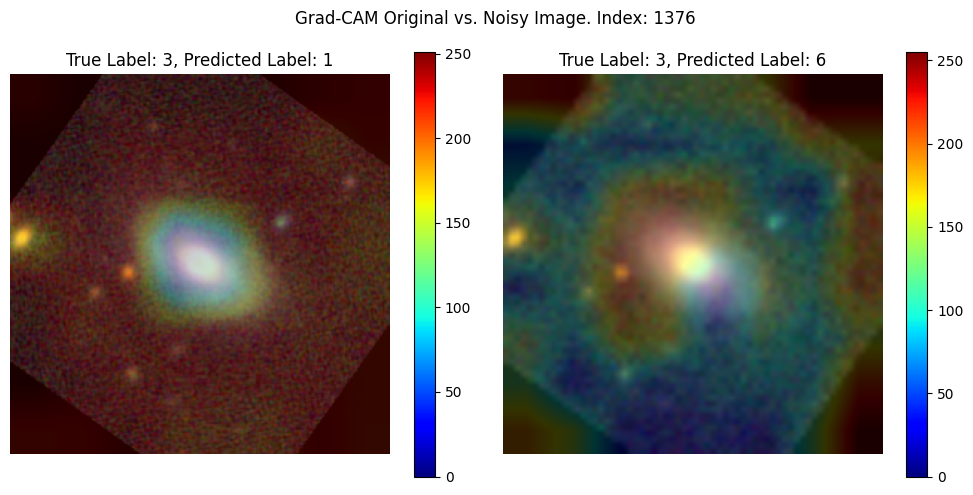

In [117]:
grad_cam = GradCAM(model=model_3)
activation_map_og = grad_cam(og_image.to(device))
activation_map_snr = grad_cam(snr_image.to(device))

# For visualization
og_img = og_image.squeeze().permute(1,2,0)  # Convert to [H, W, C] format
snr_img = snr_image.squeeze().permute(1,2,0)  # Convert to [H, W, C] format
og_result = visualize(og_img, activation_map_og.cpu().data.numpy())
snr_result = visualize(snr_img, activation_map_snr.cpu().data.numpy())
og_output = model_3(og_image.to(device))
snr_output = model_3(snr_image.to(device))
_ , og_predicted_class = torch.max(og_output, 1)
_ , snr_predicted_class = torch.max(snr_output, 1)
## make side by side plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(f'Grad-CAM Original vs. Noisy Image. Index: {index}')
cax1 = ax[0].imshow(og_result, cmap='jet')
cax2 = ax[1].imshow(snr_result, cmap='jet')
plt.colorbar(cax1, ax=ax[0])  # This line adds the colorbar
plt.colorbar(cax2, ax=ax[1])  # This line adds the colorbar
ax[0].set_title(f'True Label: {og_label.item()}, Predicted Label: {og_predicted_class.item()}')
ax[1].set_title(f'True Label: {snr_label.item()}, Predicted Label: {snr_predicted_class.item()}')
ax[0].axis('off')
ax[1].axis('off')

plt.tight_layout()
plt.show()